***
# Load Packages

In [1]:
import numpy as np
import pandas as pd
import os
import email
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,classification_report,completeness_score
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from bs4 import BeautifulSoup
import re

***
# Import Data

In [2]:
#load data functions
def flag_emails(dirpath, positive_indicator="spam"):
    if positive_indicator in dirpath:
        return 1
    else:
        return 0 
    
# https://docs.python.org/2.4/lib/standard-encodings.html
def import_messages(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp1256", positive_indicator="spam"):
    
    messages = {"message":[], "label":[]}
    
    for dirpath, dirnames, filenames in os.walk(root_dir, topdown=False):
        for name in filenames:
            fullpath = os.path.join(dirpath, name)
            messages['label'].append(flag_emails(dirpath=dirpath, positive_indicator=positive_indicator))
            with open(fullpath,'r', encoding=encoding) as f:
                try:
                    msg = email.message_from_file(f)
                    messages['message'].append(msg)
                except UnicodeDecodeError as e:
                    print(f"Error occured with encoding type: {encoding}\n{e}")
                    return
                 
    return messages

def create_email_string(message):
    msg_text = ""
    for msg_part in message.walk():
        if "text" in msg_part.get_content_type():
            msg_text = msg_text + " " + msg_part.get_payload()
    return msg_text

def import_emails(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp1256", positive_indicator="spam"):
    
    messages = import_messages(root_dir=root_dir, 
                               encoding=encoding, 
                               positive_indicator=positive_indicator)
    
    messages['text'] = [create_email_string(message=msg) for msg in messages['message']]

    df = pd.DataFrame(messages)
    first_cols = ['text', 'label']
    df = df.loc[:, first_cols]

    return df

In [3]:
emails = import_emails(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp437", positive_indicator="spam")

***
### Preprocess Data

In [5]:
def remove_tags(html):
    soup = BeautifulSoup(html, "html.parser")
    for data in soup(['style', 'script']):
        data.decompose()
    return ' '.join(soup.stripped_strings)

emails['text'] = emails['text'].apply(remove_tags)

/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [6]:
def clean_email(email):
    email = re.sub("\d+", " ", email)
    email = email.replace('\n', ' ')
    email = email.translate(str.maketrans("", "", punctuation))
    email = email.lower()
    return email

emails['text'] = emails['text'].apply(clean_email)

In [7]:
def preproces_text(email):

    words = ""
    stemmer = SnowballStemmer("english")
    email = email.split()
    for word in email:
        words = words + stemmer.stem(word) + " "
    return words

emails['text_stemmed'] = emails['text'].apply(preproces_text)

***
### Create WordCloud

In [8]:
def remove_stop_words(sentence):
    stop_words = stopwords.words('english')
    new_stopwords = ["c", "b", "e", "f","l"]
    stop_words.extend(new_stopwords)
    word_list=sentence.split()
    clean_sentence=' '.join([w for w in word_list if w.lower() not in stop_words])
    return(clean_sentence)


In [9]:
emails['text_wo_sw'] = emails['text'].apply(remove_stop_words)

In [10]:

df_spam = emails.loc[emails['label']==1]
df_ham = emails.loc[emails['label']==0]


spam_counter = Counter(" ".join(df_spam['text_wo_sw']).split()).most_common(100)
spam_result = pd.DataFrame(spam_counter, columns=['Word', 'Frequency'])

ham_counter = Counter(" ".join(df_ham['text_wo_sw']).split()).most_common(100)
ham_result = pd.DataFrame(ham_counter, columns=['Word', 'Frequency'])



In [11]:

wc_ham = WordCloud(background_color='white',min_word_length=2).generate(' '.join(ham_result['Word']))
wc_spam = WordCloud(background_color='white',min_word_length=2).generate(' '.join(spam_result['Word']))

Non-Spam WordCloud (Top 100 Words)


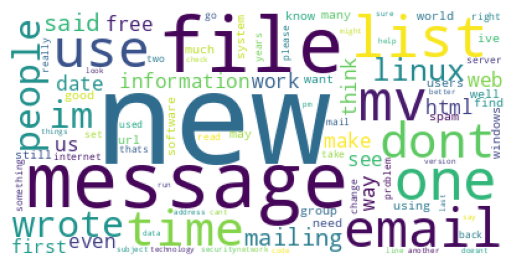

Spam WordCloud (Top 100 Words)


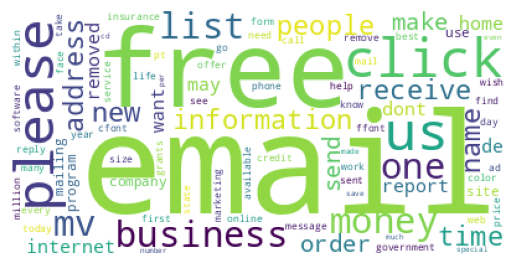

In [12]:
print('Non-Spam WordCloud (Top 100 Words)')
plt.imshow(wc_ham)
plt.axis("off")
plt.show()

In [ ]:
print('Spam WordCloud (Top 100 Words)')
plt.imshow(wc_spam)
plt.axis("off")
plt.show()

***
# Begin Modeling:

In [13]:
#create features and response frames
X = emails['text_stemmed']
y = emails['label']

In [14]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                       stop_words='english')

X = vectorizer.fit_transform(X)


In [15]:

# Create a train/test split using 20% test size.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0,
                                                    stratify=y)

feature_names = vectorizer.get_feature_names_out()
print("Number of different words: {0}".format(len(feature_names)))
print("Word example: {0}".format(feature_names[5369]))

# Check the split printing the shape of each set.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Number of different words: 84079
Word example: beckley
(7482, 84079) (7482,)
(1871, 84079) (1871,)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1391
           1       0.99      0.93      0.96       480

    accuracy                           0.98      1871
   macro avg       0.98      0.97      0.97      1871
weighted avg       0.98      0.98      0.98      1871



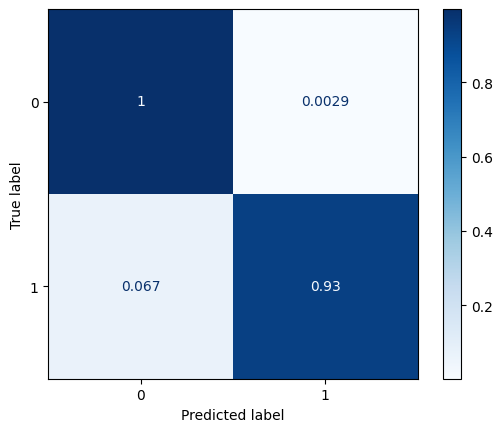

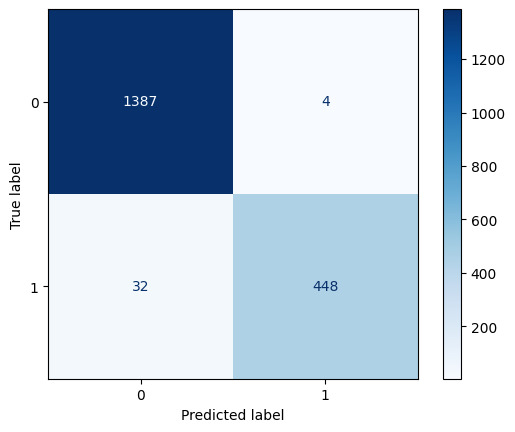

In [16]:
# Create classifier.
clf = MultinomialNB(alpha=.2)

# Fit the classifier on the training features and labels.
clf.fit(X_train, y_train)

# Make prediction - Store predictions in a list named pred.
pred = clf.predict(X_test)

print(classification_report(y_test,pred))
ConfusionMatrixDisplay.from_predictions(y_test,pred,normalize='true',cmap='Blues');
ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test,cmap='Blues');